SOGComp is SOG run for comparison with SS2DSOG5x5
- compare starting values to check initialization of IC's

In [1]:
import numpy as np
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import netCDF4 as nc
import os
import re
import pytz

%matplotlib inline

read in SOG data:

In [2]:
filename='/data/eolson/SOG/SOG-runs/SOGCompNoZooTest/profiles/hoff-SOG.dat'
file_obj = open(filename, 'rt')
for index, line in enumerate(file_obj):
    line = line.strip()
    if line.startswith('*FieldNames:'):
        field_names = line.split(': ', 1)[1].split(', ')
    elif line.startswith('*FieldUnits:'):
        field_units = line.split(': ', 1)[1].split(', ')
    elif line.startswith('*HoffmuellerStartYr:'):
        year_start = line.split(': ', 1)[1]
    elif line.startswith('*HoffmuellerStartDay:'):
        day_start = line.split(': ', 1)[1]
    elif line.startswith('*HoffmuellerStartSec:'):
        sec_start = line.split(': ', 1)[1]
    elif line.startswith('*HoffmuellerInterval:'):
         interval = line.split(': ', 1)[1]
    elif line.startswith('*EndOfHeader'):
        break
data = pd.read_csv(filename, delim_whitespace=True, header=0, names=field_names, skiprows=index, chunksize=102)
# Timestamp in matplotlib time
dt_num = dts.date2num(dtm.datetime.strptime(year_start + ' ' + day_start, '%Y %j')) + float(sec_start)/86400
interval=float(interval)
# Extract dataframe chunks into dictionary
for index, chunk in enumerate(data):
    if index==0:
        da=chunk
    else:
        da=np.dstack((da,chunk))
z=da[:,0,0]
t=np.arange(da.shape[2])
t=(t+1.0)*20
tt,zz=np.meshgrid(t,-z)
print field_names
print t

['depth', 'temperature', 'salinity', 'sigma-t', 'micro phytoplankton', 'nano phytoplankton', 'pico phytoplankton', 'micro zooplankton', 'nitrate', 'ammonium', 'silicon', 'dissolved inorganic carbon', 'dissolved oxygen', 'alkalinity', 'DOC detritus', 'POC detritus', 'DON detritus', 'PON detritus', 'refractory N detritus', 'biogenic Si detritus', 'total momentum eddy diffusivity', 'total temperature eddy diffusivity', 'total salinity eddy diffusivity', 'photosynthetic available radiation', 'u velocity', 'v velocity']
[ 0.  0.  0. ...,  0.  0.  0.]


In [22]:
print day_start
print dts.num2date(dt_num)
print z

293
2004-10-19 00:00:00+00:00
[   0.     0.5    1.5    2.5    3.5    4.5    5.5    6.5    7.5    8.5
    9.5   10.5   11.5   12.5   13.5   14.5   15.5   16.5   17.5   18.5
   19.5   20.5   21.5   22.5   23.5   24.5   25.5   26.5   27.5   28.5
   29.5   30.5   31.5   32.5   33.5   34.5   35.5   36.5   37.5   38.5
   39.5   40.5   41.5   42.5   43.5   44.5   45.5   46.5   47.5   48.5
   49.5   50.5   51.5   52.5   53.5   54.5   55.5   56.5   57.5   58.5
   59.5   60.5   61.5   62.5   63.5   64.5   65.5   66.5   67.5   68.5
   69.5   70.5   71.5   72.5   73.5   74.5   75.5   76.5   77.5   78.5
   79.5   80.5   81.5   82.5   83.5   84.5   85.5   86.5   87.5   88.5
   89.5   90.5   91.5   92.5   93.5   94.5   95.5   96.5   97.5   98.5
   99.5  100. ]


load SS2DSOG5x5 data:

In [7]:
resultsDir='/data/eolson/MEOPAR/SS2DSOGruns/run5x5_08/'
fname='SalishSea_1h_20041019_20041020_grid_T.nc'
f=nc.Dataset(os.path.join(resultsDir,fname))
fkeys=f.variables.keys()
lons=f.variables['nav_lon'][1,:]
lats=f.variables['nav_lat'][:,1]
for ik in fkeys:
    match = re.search(r'depth.',ik)
    if match:
        zkey=match.group(0)
zSS=f.variables[zkey][:]
xxSS,zzSS=np.meshgrid(lons,-z[:])
xtSS,ytSS=np.meshgrid(lons,lats)
print fkeys
#print f.variables['deptht'][:]

[u'nav_lon', u'nav_lat', u'deptht', u'time_counter', u'sossheig', u'votemper', u'vosaline', u'rain_rate', u'snow_rate']


plot phys IC's in same axes:

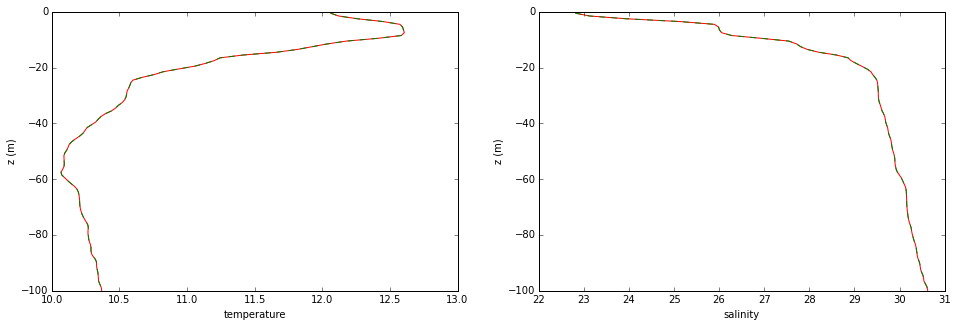

In [8]:
fig, axs = plt.subplots(1,2,figsize=(16,5))

# Temperature
iii=1
pl0=axs[0].plot(da[:,iii,0],-z,color='r')
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel(field_names[iii])
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['votemper'][:,:,:,:]
pl3=axs[0].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='g')

# Sal
iii=2
pl0=axs[1].plot(da[:,iii,0],-z,'-',color='r')
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel(field_names[iii])
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['vosaline'][:,:,:,:]
pl3=axs[1].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='g')
f.close()

Load SS2DSOG nuts & bio data:

In [9]:
resultsDir='/data/eolson/MEOPAR/SS2DSOGruns/run5x5_08/'
fname='SalishSea_1h_20041019_20041020_ptrc_T.nc'
f=nc.Dataset(os.path.join(resultsDir,fname))
fkeys=f.variables.keys()
lons=f.variables['nav_lon'][1,:]
lats=f.variables['nav_lat'][:,1]
for ik in fkeys:
    match = re.search(r'depth.',ik)
    if match:
        zkey=match.group(0)
zSS=f.variables[zkey][:]
xxSS,zzSS=np.meshgrid(lons,-z[:])
xtSS,ytSS=np.meshgrid(lons,lats)
print fkeys

[u'nav_lon', u'nav_lat', u'deptht', u'time_counter', u'DIC', u'Alkalini', u'O2', u'CaCO3', u'PO4', u'POC', u'Si', u'PHY', u'ZOO', u'DOC', u'PHY2', u'ZOO2', u'DSi', u'Fer', u'BFe', u'GOC', u'SFe', u'DFe', u'GSi', u'NFe', u'NCHL', u'DCHL', u'NO3', u'NH4']


Load IC's prepared for SS2DSOG5x5:

In [10]:
f2name='/data/eolson/MEOPAR/SS2DSOGruns/nuts_SOG5x5_S3-2014-10-19.nc'
f2=nc.Dataset(f2name)

Plot 3 phyto from SOG, PHY and PHY2 from SS2DSOG (L) and NO3 (R):

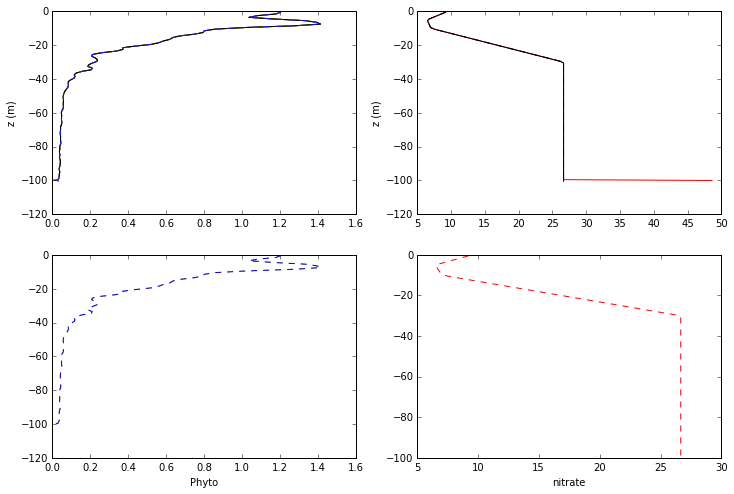

In [11]:
fig, axs = plt.subplots(2,2,figsize=(12,8))

# Phyto
iii=4
pl0=axs[0,0].plot(da[:,iii,0],-z,'-',color='r')
#iii=5
#pl0=axs[0,0].plot(da[:,iii,0],-z,'-',color='b')
iii=6
pl0=axs[0,0].plot(da[:,iii,0],-z,'-',color='g')
pl0=axs[0,0].plot(f2.variables['PHY'][0,0:101,2,2],-zSS[0:101],'-',color='k')
axs[0,0].set_ylabel('z (m)')
axs[1,0].set_xlabel('Phyto')
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar1=f.variables['PHY'][:,:,:,:]
pl3=axs[1,0].plot(ivar1[0,0:101,2,2],-zSS[0:101],'--',color='y')
pl3=axs[0,0].plot(ivar1[0,0:101,2,2],-zSS[0:101],'--',color='y')
ivar2=f.variables['PHY2'][:,:,:,:]
pl3=axs[1,0].plot(ivar2[0,0:101,2,2],-zSS[0:101],'--',color='b')
pl3=axs[0,0].plot(ivar2[0,0:101,2,2],-zSS[0:101],'--',color='b')
#axs[0,0].set_xlim([0,1])
#print da[0:101,5,0]/ivar2[0,0:101,2,2]
#print da[0:101,6,0]/ivar1[0,0:101,2,2]

# NO
iii=8
pl0=axs[0,1].plot(da[:,iii,0],-z,'-',color='r')
pl0=axs[0,1].plot(f2.variables['NO3'][0,0:101,2,2],-zSS[0:101],'-',color='k')
axs[0,1].set_ylabel('z (m)')
axs[1,1].set_xlabel(field_names[iii])
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['NO3'][:,:,:,:]
pl3=axs[1,1].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='r')
pl3=axs[0,1].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='k')
#print ivar[0,0:100,2,2]
#print da[0:101,iii,0]/ivar[0,0:101,2,2]

In [12]:
print f.variables['NH4'].shape

(17280, 101, 5, 5)


Plot Si (L) and NH4 (R)

(0.8, 1.2)

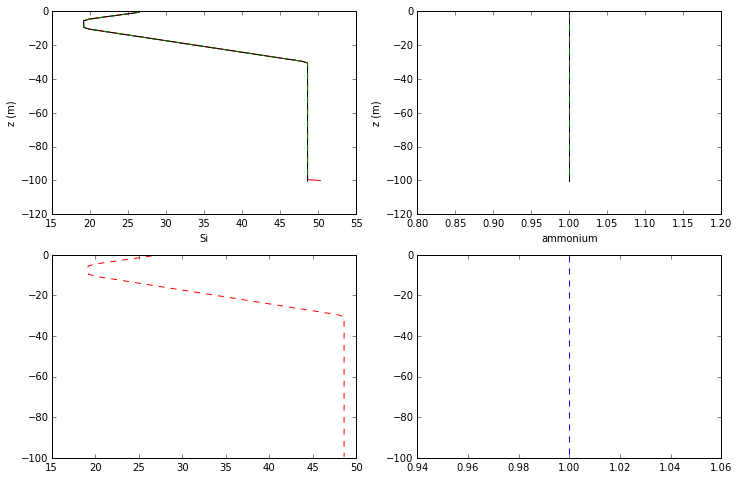

In [13]:
fig, axs = plt.subplots(2,2,figsize=(12,8))

# Si
iii=10
pl0=axs[0,0].plot(da[:,iii,0],-z,'-',color='r')
axs[0,0].set_ylabel('z (m)')
axs[0,0].set_xlabel('Si')
pl0=axs[0,0].plot(f2.variables['Si'][0,0:101,2,2],-zSS[0:101],'-',color='k')
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['Si'][:,:,:,:]
pl3=axs[1,0].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='r')
pl4=axs[0,0].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='g')
#print da[0:100,iii,0]/ivar[0,0:100,2,2]

# NH4
iii=9
pl0=axs[0,1].plot(da[:,iii,0],-z,'-',color='b')
pl0=axs[0,1].plot(f2.variables['NH4'][0,0:101,2,2],-zSS[0:101],'-',color='k')
axs[0,1].set_ylabel('z (m)')
axs[0,1].set_xlabel(field_names[iii])
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['NH4'][:,:,:,:]
pl3=axs[1,1].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='b')
pl4=axs[0,1].plot(ivar[0,0:100,2,2],-zSS[0:100],'--',color='g')
axs[0,1].set_xlim([.8,1.2])
#print da[0:100,iii,0]/ivar[0,0:100,2,2]

REPEAT WITH LATER TIME FOR NEMO:

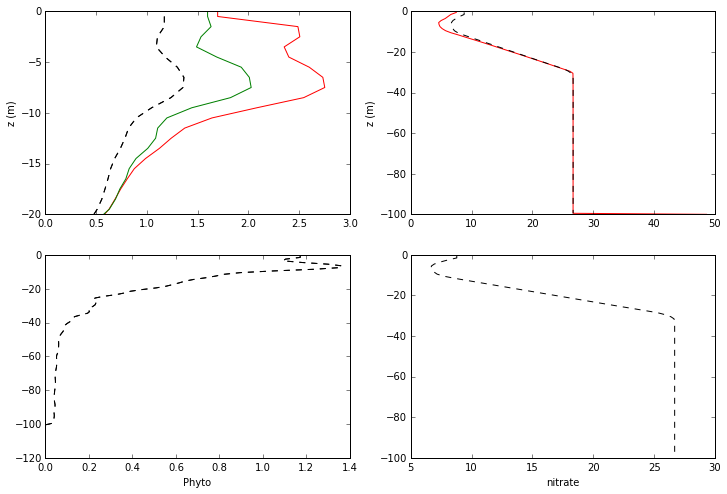

In [14]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
ti=12 # hrs since start

# Phyto
iii=4
pl0=axs[0,0].plot(da[:,iii,360*ti],-z,'-',color='r')
#iii=5
#pl0=axs[0,0].plot(da[:,iii,ti],-z,'-',color='b')
iii=6
pl0=axs[0,0].plot(da[:,iii,360*ti],-z,'-',color='g')
#pl0=axs[0,0].plot(f2.variables['PHY'][0,0:101,2,2],-zSS[0:101],'-',color='k')
axs[0,0].set_ylabel('z (m)')
axs[1,0].set_xlabel('Phyto')
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar1=f.variables['PHY'][:,:,:,:]
pl3=axs[1,0].plot(ivar1[360*ti,0:101,2,2],-zSS[0:101],'--',color='k')
pl3=axs[0,0].plot(ivar1[360*ti,0:101,2,2],-zSS[0:101],'--',color='k')
ivar2=f.variables['PHY2'][:,:,:,:]
pl3=axs[1,0].plot(ivar2[360*ti,0:101,2,2],-zSS[0:101],'--',color='k')
pl3=axs[0,0].plot(ivar2[360*ti,0:101,2,2],-zSS[0:101],'--',color='k')
axs[0,0].set_ylim([-20,0])

# NO
iii=8
pl0=axs[0,1].plot(da[:,iii,360*ti],-z,'-',color='r')
#pl0=axs[0,1].plot(f2.variables['NO3'][0,0:101,2,2],-zSS[0:101],'-',color='k')
axs[0,1].set_ylabel('z (m)')
axs[1,1].set_xlabel(field_names[iii])
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['NO3'][:,:,:,:]
pl3=axs[1,1].plot(ivar[360*ti-1,0:100,2,2],-zSS[0:100],'--',color='k')
pl3=axs[0,1].plot(ivar[360*ti-1,0:100,2,2],-zSS[0:100],'--',color='k')
#print ivar[0,0:100,2,2]


(0.8, 1.2)

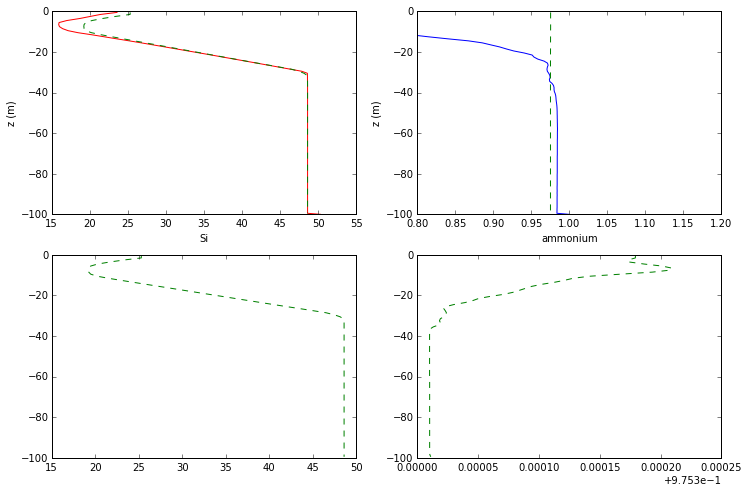

In [15]:
fig, axs = plt.subplots(2,2,figsize=(12,8))

# Si
iii=10
pl0=axs[0,0].plot(da[:,iii,360*ti],-z,'-',color='r')
axs[0,0].set_ylabel('z (m)')
axs[0,0].set_xlabel('Si')
#pl0=axs[0,0].plot(f2.variables['Si'][0,0:101,2,2],-zSS[0:101],'-',color='k')
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['Si'][:,:,:,:]
pl3=axs[1,0].plot(ivar[360*ti,0:100,2,2],-zSS[0:100],'--',color='g')
pl4=axs[0,0].plot(ivar[360*ti,0:100,2,2],-zSS[0:100],'--',color='g')

# NH4
iii=9
pl0=axs[0,1].plot(da[:,iii,360*ti],-z,'-',color='b')
#pl0=axs[0,1].plot(f2.variables['NH4'][0,0:101,2,2],-zSS[0:101],'-',color='k')
axs[0,1].set_ylabel('z (m)')
axs[0,1].set_xlabel(field_names[iii])
#pl1=axs[0].plot(da[:,iii,da.shape[2]-1],-z)
ivar=f.variables['NH4'][:,:,:,:]
pl3=axs[1,1].plot(ivar[360*ti,0:100,2,2],-zSS[0:100],'--',color='g')
pl4=axs[0,1].plot(ivar[360*ti,0:100,2,2],-zSS[0:100],'--',color='g')
axs[0,1].set_xlim([.8,1.2])

In [16]:
f.close()
f2.close()

In [17]:
fname='SalishSea_1h_20041019_20041020_diad_T.nc'
f=nc.Dataset(os.path.join(resultsDir,fname))
fkeys=f.variables.keys()
lons=f.variables['nav_lon'][1,:]
lats=f.variables['nav_lat'][:,1]
times=np.copy(f.variables['time_counter'])/3600
for ik in fkeys:
    match = re.search(r'depth.',ik)
    if match:
        zkey=match.group(0)
zSS=f.variables[zkey][:]
xxSS,zzSS=np.meshgrid(lons,-zSS)
xtSS,ytSS=np.meshgrid(lons,lats)
tt2,zz2=np.meshgrid(times,-zSS)
print fkeys
#print f.variables['PAR'].shape
#print f.variables['time_counter']

[u'nav_lon', u'nav_lat', u'deptht', u'time_counter', u'PAR', u'PPPHY', u'PPPHY2', u'PPNEWN', u'PPNEWD']


In [21]:
iii=23
print np.shape(da[:,iii,:])
print np.shape(np.transpose(f.variables['PAR'][:,0:100,2,2]))
print zz[0:5,0]
print zz2[0:5,0]
print np.max(f.variables['PAR'])
print np.max(da[:,iii,:])
print '--'
print f.variables['time_counter'][15*360]/3600
print '--'
print f.variables['PAR'][15*360,0:5,2,2]
print da[0:5,iii,15*360/2]
print '+++'
print zzSS.shape
print f.variables['PAR'].shape
print tt[0,:]

(102, 8641)
(100, 17280)
[-0.  -0.5 -1.5 -2.5 -3.5]
[-0.5 -1.5 -2.5 -3.5 -4.5]
145.217
180.0475
--
15.0027777778
--
[ 85.38528442  54.84986877  39.14299774  29.96400642  24.04101753]
[ 105.9269   85.4353   54.882    39.1659   29.9816]
+++
(101, 5)
(17280, 101, 5, 5)
[ 0.  0.  0. ...,  0.  0.  0.]


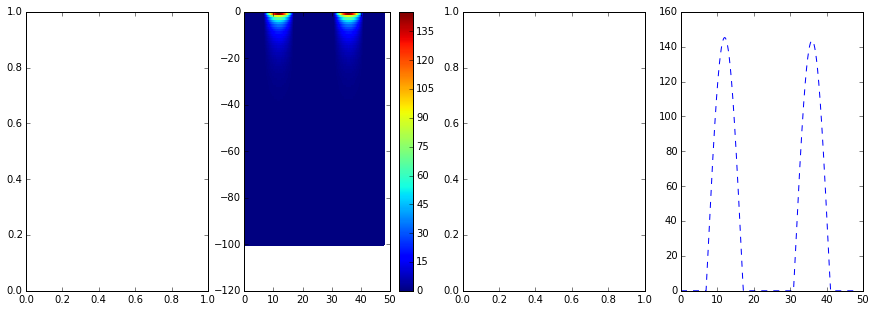

In [19]:
fig, axs = plt.subplots(1,4,figsize=(15,5))
mesh1=axs[1].pcolormesh(tt2,zz2,np.transpose(f.variables['PAR'][:,:,2,2]))
fig.colorbar(mesh1,ax=axs[1])
pl2=axs[3].plot(tt2[4,:],f.variables['PAR'][:,0,2,2],'--')

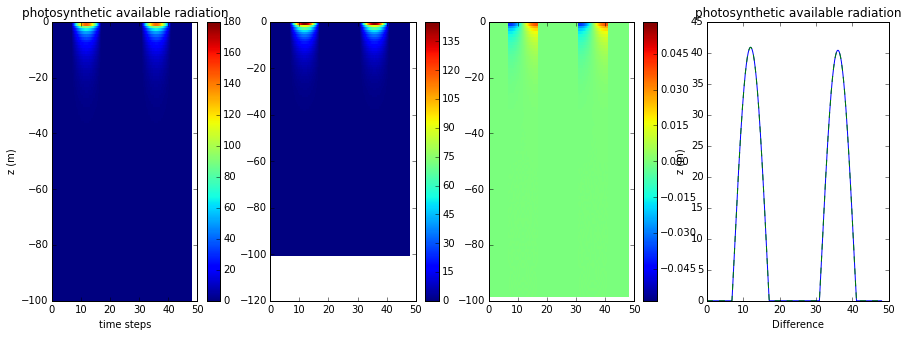

In [24]:
iii=23
fig, axs = plt.subplots(1,4,figsize=(15,5))
mesh0=axs[0].pcolormesh(tt[:,0:(48*360/2)]/3600,zz[:,0:(48*360/2)],da[:,iii,0:(48*360/2)])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])
#0:48*360:360
mesh1=axs[1].pcolormesh(tt2,zz2,np.transpose(f.variables['PAR'][:,:,2,2]))
fig.colorbar(mesh1,ax=axs[1])

mesh2=axs[2].pcolormesh(tt[0:100,0:(48*360/2)]/3600,zz[0:100,0:(48*360/2)],da[1:101,iii,0:(48*360/2)]-np.transpose(f.variables['PAR'][0:(48*360):2,0:100,2,2]))
fig.colorbar(mesh2,ax=axs[2])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[3].plot(tt[5,0:(47*360)]/3600,da[5,iii,0:(47*360)],'-',color='b')
pl2=axs[3].plot(tt2[4,0:(47*360)],f.variables['PAR'][0:(47*360),4,2,2],'--',color='g')
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel('Difference')
axs[3].set_title(field_names[iii])

In [44]:
print da[5,iii,5850:5858]

[ 18.3491  18.4101  18.4709  18.5318  18.5925  18.6533  18.714   18.7746]


4


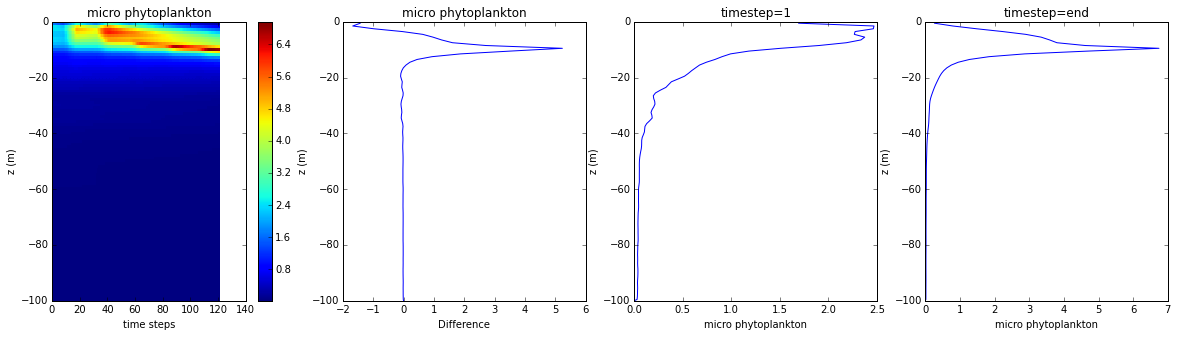

In [12]:
iii=4
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

5


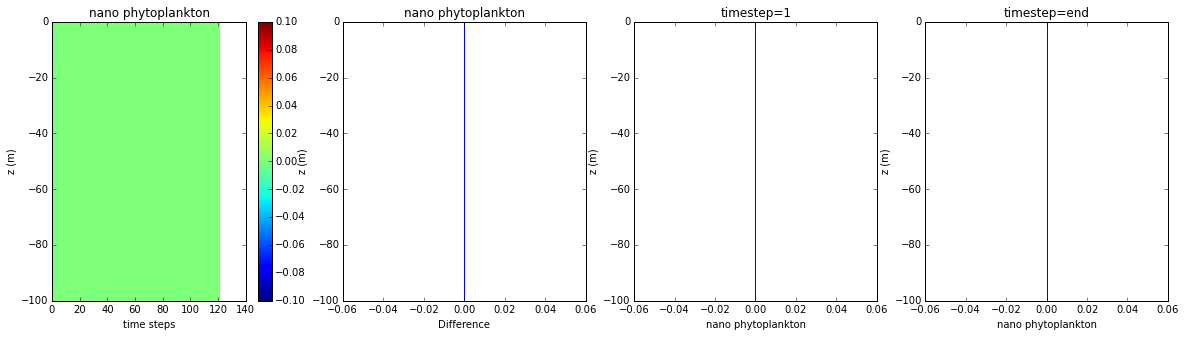

In [13]:
iii=5
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

6


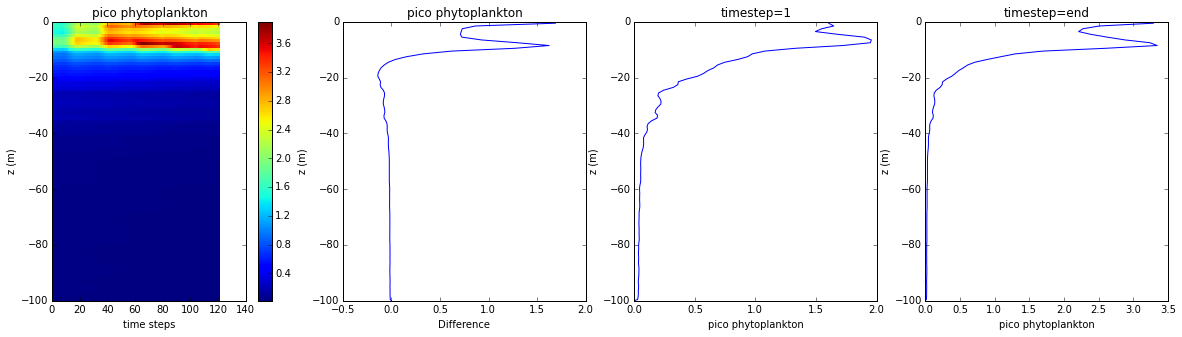

In [14]:
iii=6
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

7


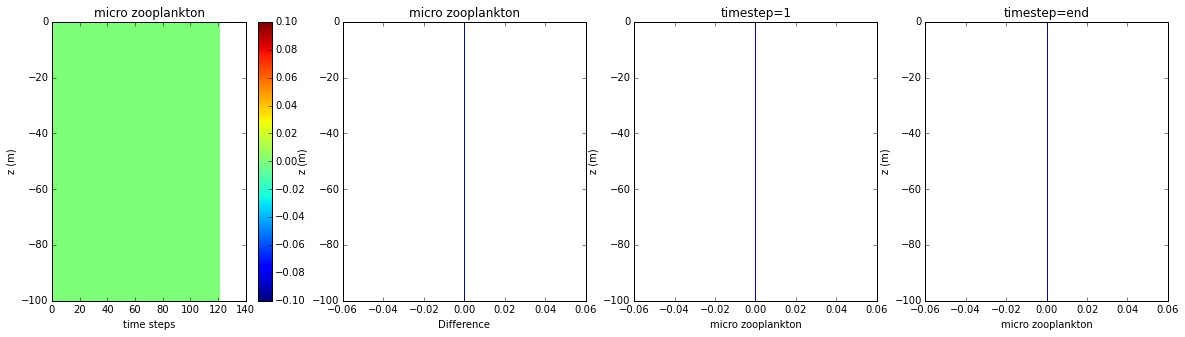

In [15]:
iii=7
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

8


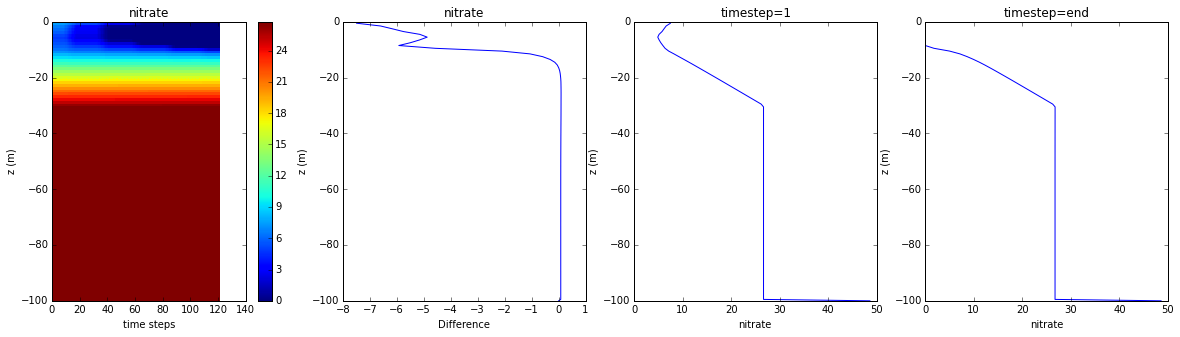

In [16]:
iii=8
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

9


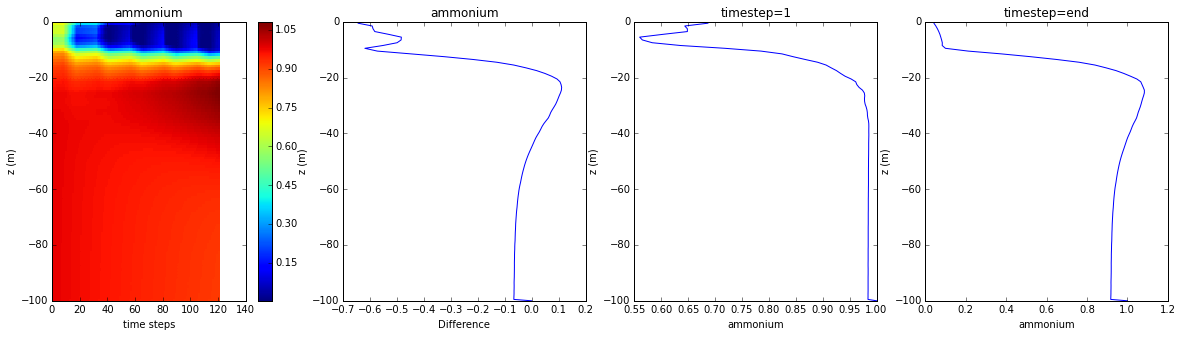

In [17]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

10


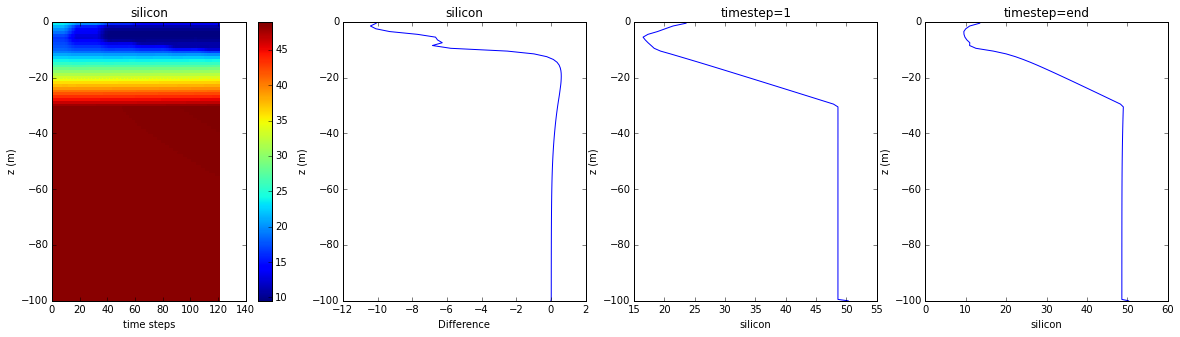

In [18]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

11


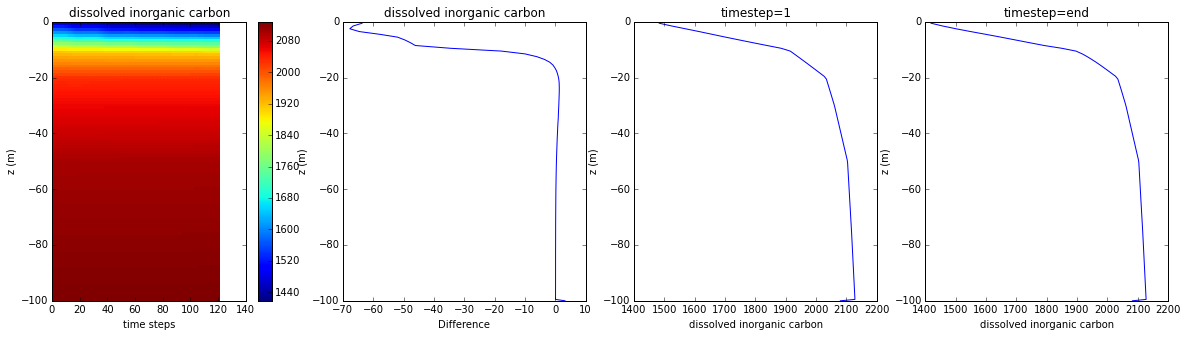

In [19]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

12


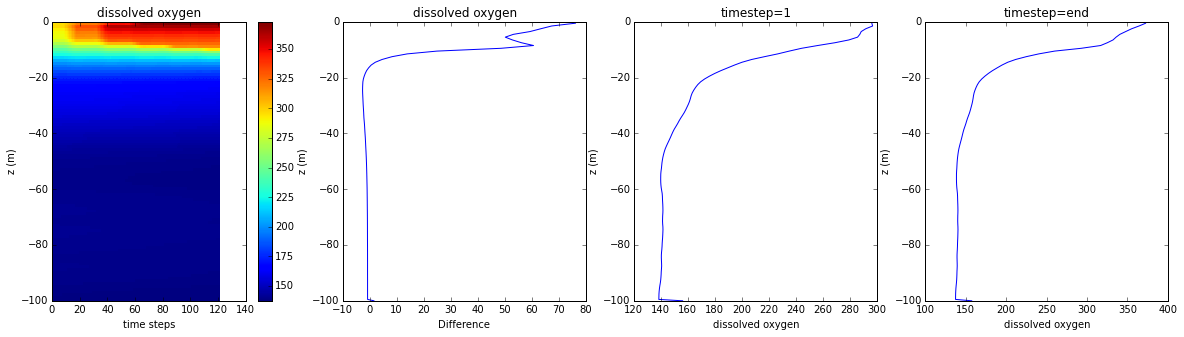

In [20]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

13


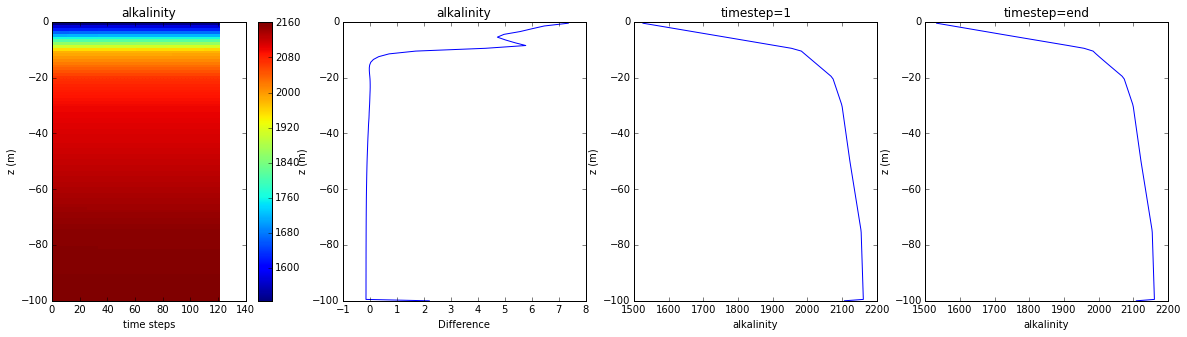

In [21]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

14


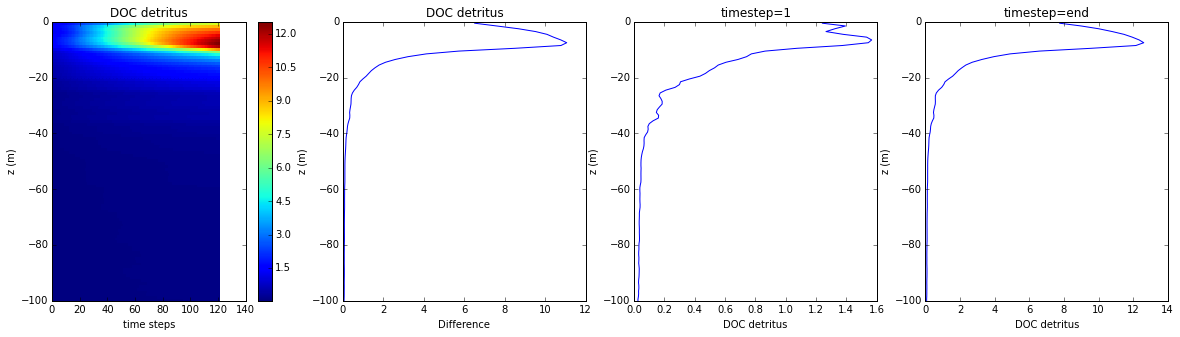

In [22]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

15


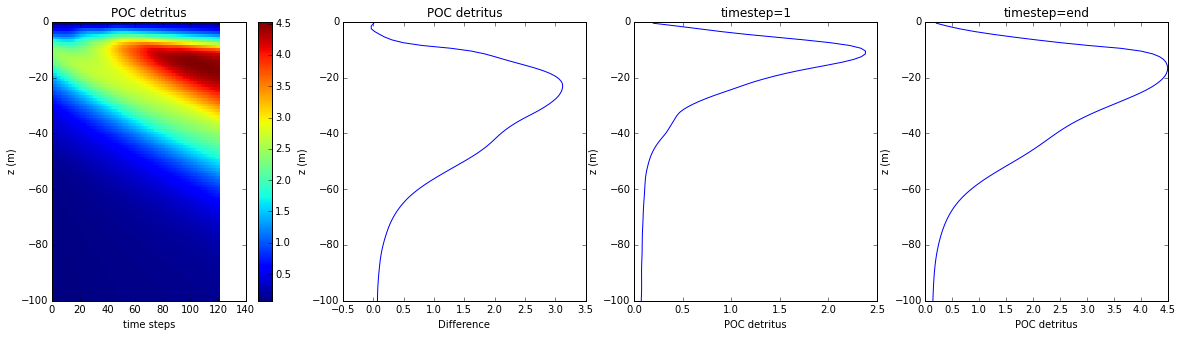

In [23]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

16


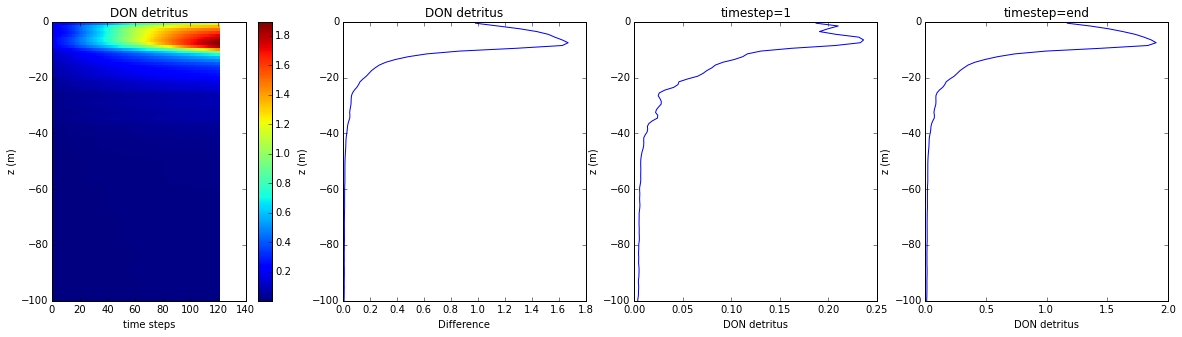

In [24]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

17


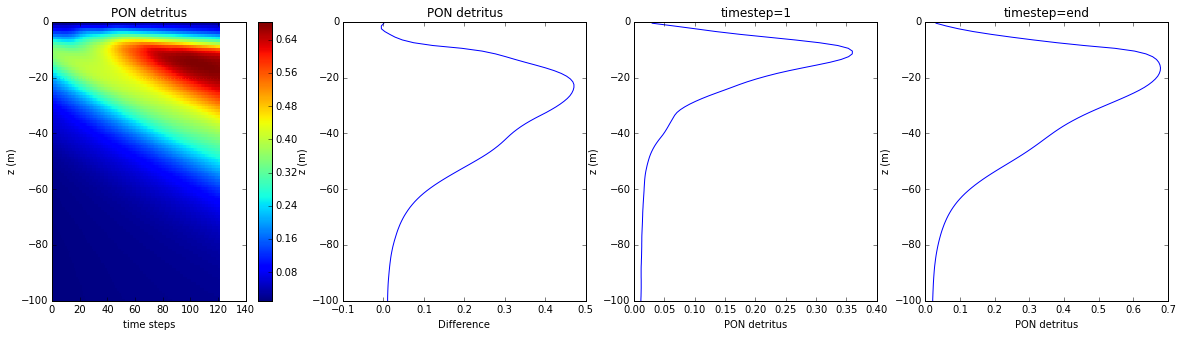

In [25]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

18


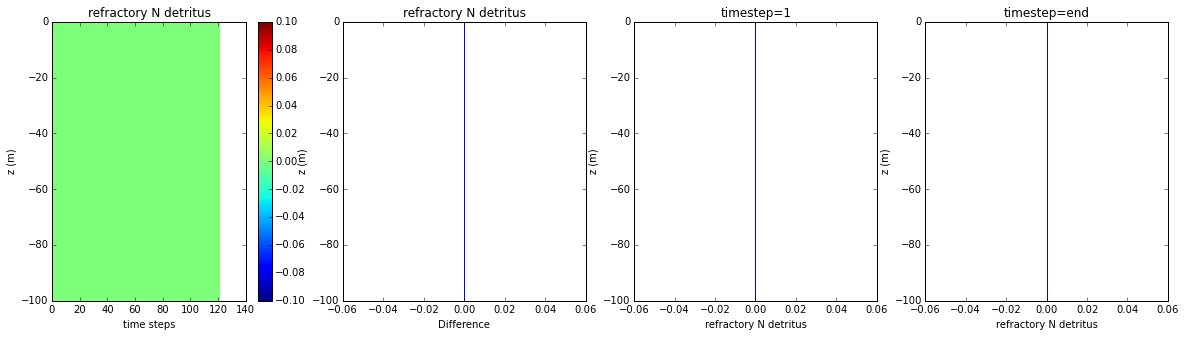

In [26]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

19


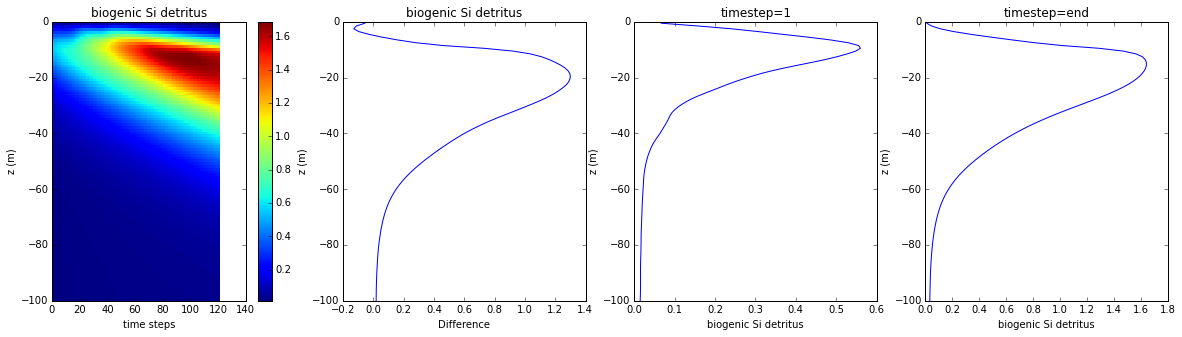

In [27]:
iii+=1
print iii

fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(d,-z)
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

In [28]:
iii+=1
print iii


20


In [29]:
iii+=1
print iii


21


In [34]:
iii+=1
print iii


22


22


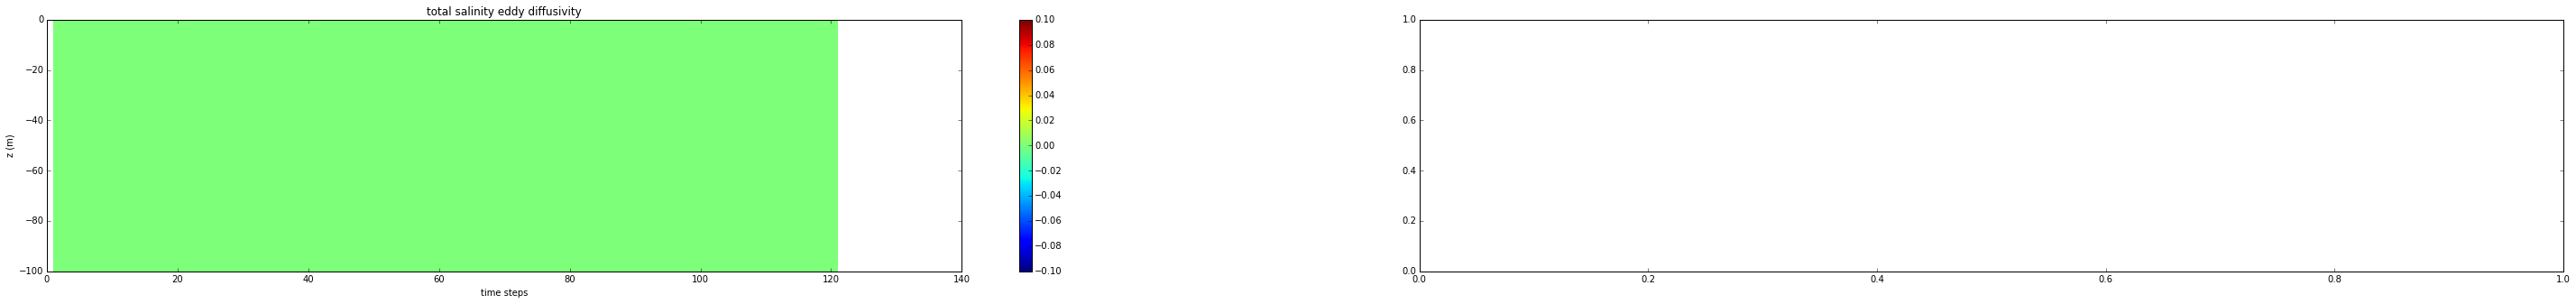

In [30]:
iii+=1
print iii

fig, axs = plt.subplots(1,2,figsize=(50,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])


In [31]:
iii+=1
print iii

23


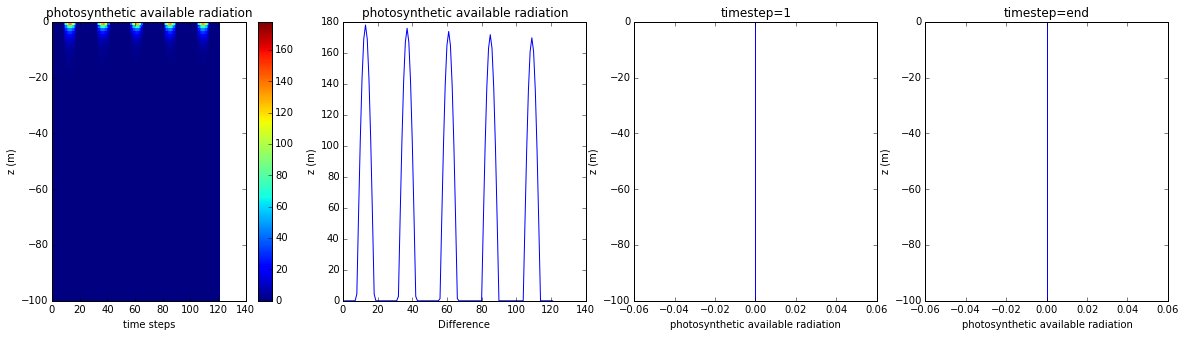

In [36]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

d=da[:,iii,da.shape[2]-1]-da[:,iii,0]
pl1=axs[1].plot(tt[0,:],da[0,iii,:])
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')

In [39]:
iii=4
print iii

4


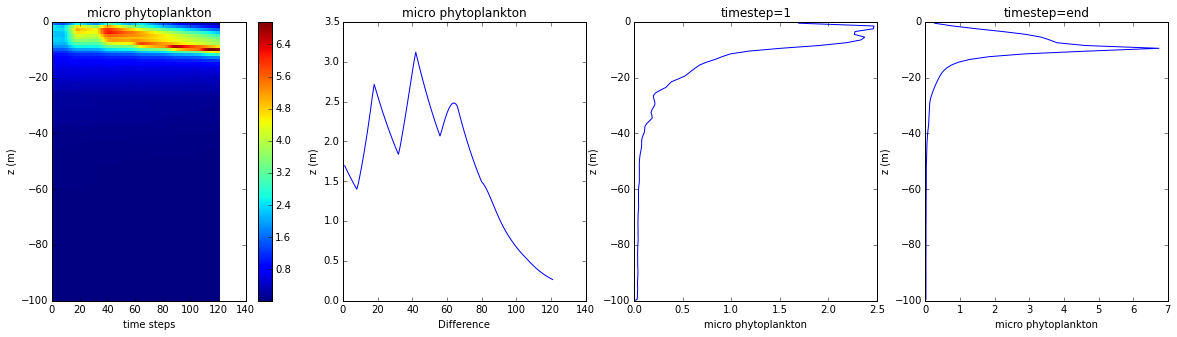

In [41]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
mesh0=axs[0].pcolormesh(tt,zz,da[:,iii,:])
fig.colorbar(mesh0,ax=axs[0])
axs[0].set_ylabel('z (m)')
axs[0].set_xlabel('time steps')
axs[0].set_title(field_names[iii])

pl1=axs[1].plot(tt[0,:],da[0,iii,:])
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('Difference')
axs[1].set_title(field_names[iii])

pl2=axs[2].plot(da[:,iii,0],-z)
axs[2].set_ylabel('z (m)')
axs[2].set_xlabel(field_names[iii])
axs[2].set_title('timestep=1')

pl3=axs[3].plot(da[:,iii,da.shape[2]-1],-z)
axs[3].set_ylabel('z (m)')
axs[3].set_xlabel(field_names[iii])
axs[3].set_title('timestep=end')